<a href="https://colab.research.google.com/github/kode-git/FER-Visual-Transformers/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis

We will analysis AVFER dataset and its properties before the data management in the preprocessing phase.

## Install Dependencies and Import Libraries


In [1]:
!pip3 install Pillow
!pip install pandas

In [2]:
# classic libraries for collections.
import pandas as pd
import numpy as np

# utility library.
import random, time, copy

# plot libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# libraries for image processing .
import os, cv2, glob, imageio, sys
from PIL import Image

# warning library for service warnings.
import warnings

# utility functions for specific uses
from __future__ import print_function
from __future__ import division


## Image Worker Implementation

ImageWorker provides some useful functions:
- Format Converter: For resize and move an image from *source_path* to *dest_path* filtered for *format_img*
- List Classes: Listing the classes and put them in an array to manipulate the subfolders for class functions divisions.
- Counter Samples per Class: Given a *dataset_path*, return a dictionary with counters of images classified by subfolders for plot or data visualization pourposes. 
- Counter Samples: Given a *dataset_path*, return a counter of images in the tree.
- Extension Converter: Convert an image format for every image in a specified path
- Counter Files Extension: Given a *path*, return the counter of image in the directory with a specific *format*
- Navigate Path: Counter every file in a subtree

In [3]:
class ImageWorker():
    """
    Image Worker class for Data Integration.
    This class manages images data, size and format.
    """
    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_path, dest_path, resize=(224,224)):
        """
        Move an image from source_path to dest_path.
        Images selected follow format_img.
        There is a default resize of (224,244).
        """
        count = 0
        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, resize, interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(dest_path + "resized_on_" + source_path + "_" + str(count) + "."+ format_img, resized)
            count += 1

    def list_classes(self, dataset_path):
        """
        List the classes of a dataset.
        """
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """
      Counts samples of classes.
      Each class has its own counter.
      Return a dictionary with (class, counter) pair.
      """
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
      """
      Counts total samples of a dataset.
      """
      a = self.counter_samples_on_class(dataset_path)
      counter = 0
      for el in a.keys():
        counter += a[el]
      return counter


    def extension_converter(self, path, format_source, format_result, dest_path):   
      """
      Convert a file from format_source to format_result.
      The file is loaded from path and the result is stored to dest_path.
      """
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """
      Counts samples in path based on format input.
      """
      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      

    def navigate_path(self, path):    
      """
      Navigate in the path and counts every file
      """
      count = 0
      for dir in os.listdir(path):
          if os.path.isfile(os.path.join(path, dir)):
              count += 1
      return count

In [4]:
# define Image Worker instance
iw = ImageWorker()

## Common utilities


We implemented some logic and reusable functions useful for the data analysis or data manipulation phases. These functions carry out support routines for ImageWorker's class. They are:
- Min, Max and Mean: According to values or set of values passed as parameter.
- Plot Dataset: Function for plot image's dataset and color values according to the mean of classes cardinalities.
- Channel Distribution: Analyze images and return counters of images for different channels dimension.

In [5]:
def mean(values):
  """
  Calculates the mean in values.
  """
  if len(values) <= 0:
    return 0
  else:
    sum = 0
    for el in values:
      sum += el
    return int(sum / len(values))

def min(val):
  """
  Calculates the minimum in val.
  """
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min


def max(val):
  """
  Calculates the maximum in val.
  """
  max = sys.minsize
  for el in val.keys():
    if val[el] > max:
      max = val[el]
  return max


def plot_dataset(dataset_path, title=""):
  """
  Plot the dataset and color bars.
  Color depends on the lower bound and upper bound.
  The mean value is the congiuntion between lower and upper bound.
  """
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  y = [class_ for class_ in classes]
  
  colors = []
  x_cap = mean(x)

  # colors identify when the elements are greater or lesser than the mean values.
  for el in x:
    if el < x_cap:
      colors.append("#BC3434")
    else:
      colors.append("#49A131")
  ax.bar(y, x, color=colors)
  plt.title(title)
  plt.show()

def plot_format(typed, format):
  """
  Plot samples considering only a specific format.
  """
  fig = plt.figure(figsize=(5.5,5.5))
  ax = fig.add_axes([0,0,1,1])
  cp = df[df['set'] == typed]
  ax.bar(cp['class'], 
       cp[format])
  plt.title(f'Amount of {format} images in the {typed} dataset')
  plt.ylabel('Number')
  plt.xlabel('Class')
  plt.show()  

def channels_distribution(dataset_path):
  """
  Lists the channels dimensions of an image and return list of counters.
  The indeces of the list are the numbers of channels.
  The values are the number of files with a specific 
  number of channels corresponding to the index.
  """
  chan_size = [0 for i in range(0, 5)]
  for path in glob.glob(dataset_path):
    for el in os.listdir(path):
       pic = imageio.imread(path + "/" + el)
       chan_size[pic.ndim] += 1
  return chan_size


## Analysis on AVFER

First of all, we need to check the amount of png and jpg on the training set. Actually, validation and testing set are in jpg image format due to the AffectNet splitting.

In [6]:
# dataset directory, classes folders and metadata dataframe declaration.
basedir = "./Vision+/Vision+/*"
subsets = [dir for dir in glob.glob(basedir)]
df = pd.DataFrame(data={"class" : [], "jpg" : [], "png" : [], "set" : []})

# put in the dataframe metadata of images of AVFER.
for dir in subsets:
  classes = [cl for cl in glob.glob(dir + "/*")]
  for cl in classes:
    st = os.path.basename(dir)
    cls = os.path.basename(cl)
    png = iw.counter_file_extension(cl, "png")
    jpg = iw.counter_file_extension(cl, "jpg")
    df2 = pd.DataFrame(data={
          "class" : [cls], 
          "jpg" : [jpg], 
          "png" : [png], 
          "set" : [st]
    }) 
    df = pd.concat([df, df2], ignore_index = True, axis = 0)

# display the head of the dataframe.
df.head()

,class,jpg,png,set
0,anger,966.0,0.0,test
1,contempt,834.0,28.0,test
2,disgust,729.0,15.0,test
3,fear,953.0,0.0,test
4,happy,14.0,1500.0,test


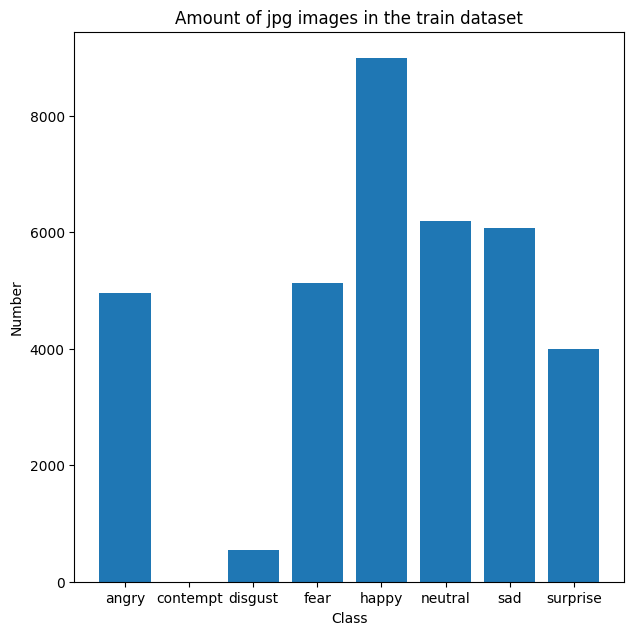

In [7]:
# plot samples in .jpg from the training set.
plot_format('train', 'jpg')

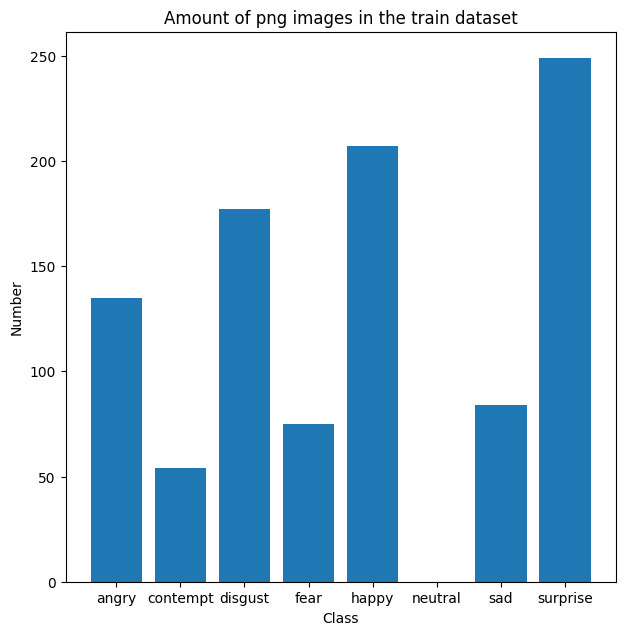

In [8]:
# plot samples in .png from the training set.
plot_format('train', 'png')

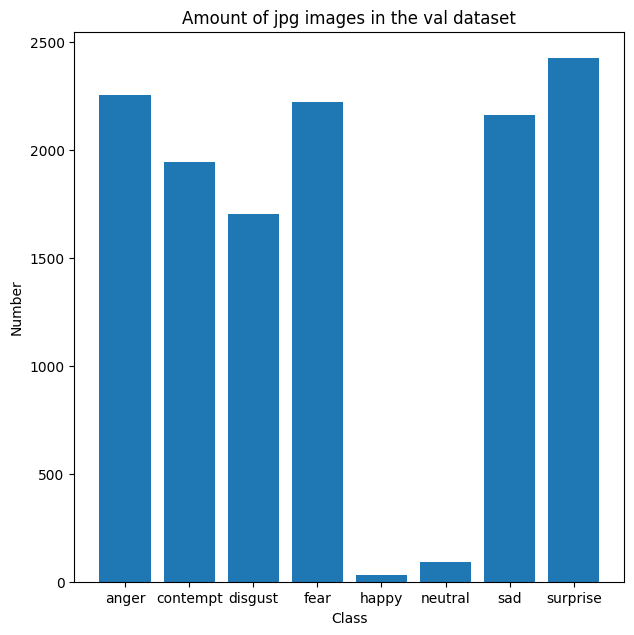

In [9]:
# AffectNet didn't have png, so we need to plot only .jpg on validation set.
plot_format('val', 'jpg') 

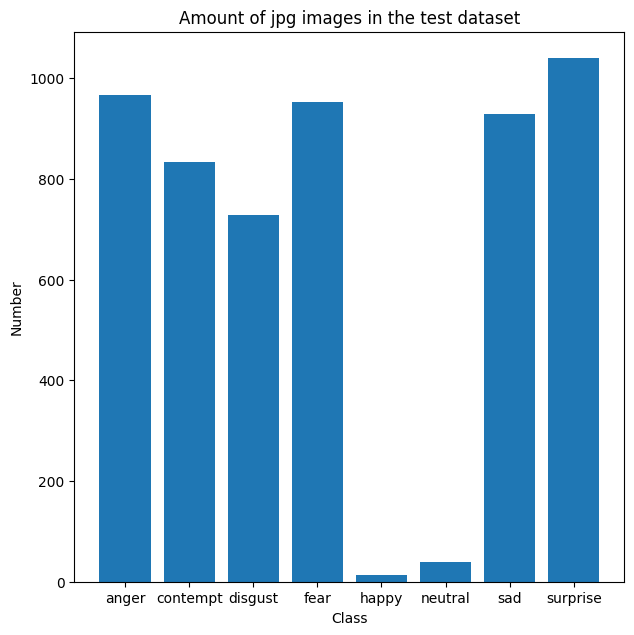

In [10]:
# AffectNet didn't have png, so we need to plot only .jpg on testing set.
plot_format('test', 'jpg')